In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Loss curves

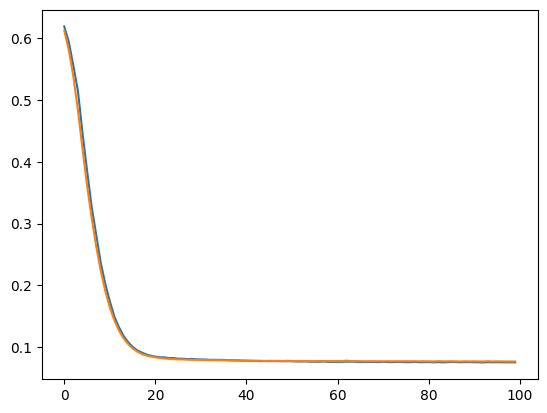

In [2]:
train_loss_curve = np.load("./ckpt/train_loss_curve.npy")
test_loss_curve = np.load("./ckpt/test_loss_curve.npy")

plt.plot(train_loss_curve, label="train")
plt.plot(test_loss_curve, label="test")

## Predicted Curve

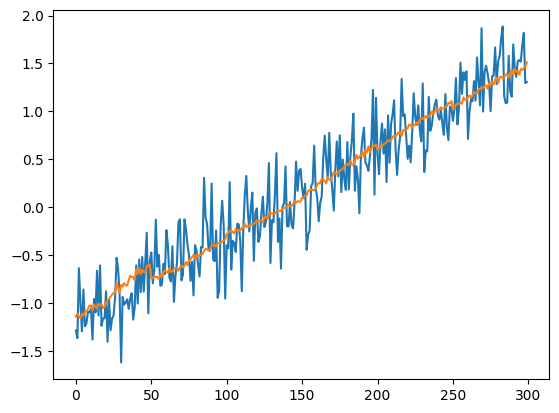

In [3]:
y = np.load("./ckpt/y.npy")
y_ = np.load("./ckpt/y_.npy")

plt.plot(y, label="y")
plt.plot(y_, label="y_")    